In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
df = pd.read_csv('data/cleaned_alzheimers_disease_data.csv')

X = df.drop(['PatientID', 'Diagnosis'], axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
 
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test) #fit_transform(X_test)

joblib.dump(scaler, 'models/tab_scaler.pkl')

['models/tab_scaler.pkl']

In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score #, roc_auc_score

In [4]:
params = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [3, 5, 10, None]},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [5, 10, None]},
    'Gradient Boosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'SVM': {'C': [0.1, 1], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']},
    'XGBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    'Naive Bayes': {} 
}

models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'Naive Bayes': GaussianNB()
}

In [5]:
results = []

for name, model in models.items():
    print(f'Навчання {name}...')
    if params[name]: 
        grid_search = GridSearchCV(model, params[name], cv=3, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_scaler, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else: 
        model.fit(X_train_scaler, y_train)
        best_model = model
        best_params = 'Default'

    y_pred = best_model.predict(X_test_scaler)
    # y_proba = best_model.predict_proba(X_test_scaler)[:,1] if hasattr(best_model, 'predict_proba') else None

    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append({
        'Model': name,
        'Best Params': best_params,
        'F1': round(f1, 3),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        # 'ROC-AUC': round(roc_auc, 3) if roc_auc is not None else 'N/A'
    })

results_df = pd.DataFrame(results)
results_df

Навчання Logistic Regression...
Навчання Decision Tree...
Навчання Random Forest...
Навчання Gradient Boosting...
Навчання KNN...
Навчання SVM...
Навчання XGBoost...
Навчання Naive Bayes...


,Model,Best Params,F1,Precision,Recall
0,Logistic Regression,{'C': 0.1},0.744,0.752,0.737
1,Decision Tree,{'max_depth': 5},0.887,0.873,0.901
2,Random Forest,"{'max_depth': 10, 'n_estimators': 50}",0.908,0.937,0.882
3,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.924,0.927,0.921
4,KNN,{'n_neighbors': 5},0.562,0.676,0.480
5,SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.743,0.743,0.743
6,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.930,0.940,0.921
7,Naive Bayes,Default,0.692,0.675,0.711


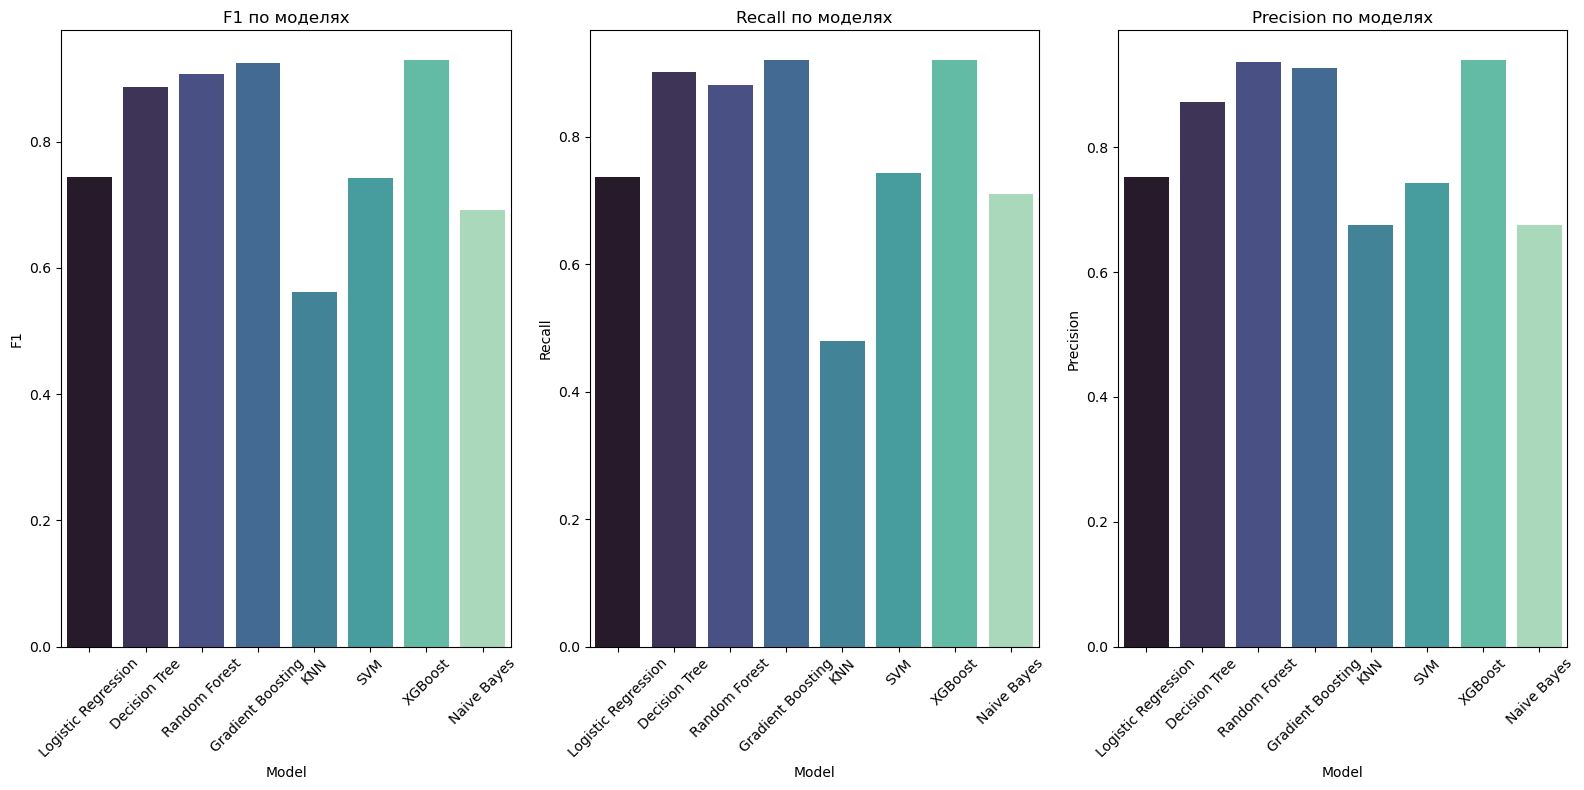

In [6]:
import seaborn as sns
plt.figure(figsize=(16,8))
metrics_to_plot = ['F1', 'Recall', 'Precision'] # , 'ROC-AUC'

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.barplot(data=results_df, x='Model', y=metric, hue='Model', palette='mako', legend=False)
    plt.title(f'{metric} по моделях')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# знайдемо модель з найкращим Recall
best_recall_model = results_df.loc[results_df['Recall'].idxmax()]

# знайдемо модель з найкращим F1
best_f1_model = results_df.loc[results_df['F1'].idxmax()]

print('-' * 15 + ' Найкраща модель за Recall: ' + '-' * 15)
print(best_recall_model)

print('\n' + '-' * 15 + ' Найкраща модель за F1:' + '-' * 15)
print(best_f1_model)


--------------- Найкраща модель за Recall: ---------------
Model                                          Gradient Boosting
Best Params    {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
F1                                                         0.924
Precision                                                  0.927
Recall                                                     0.921
Name: 3, dtype: object

--------------- Найкраща модель за F1:---------------
Model                                                    XGBoost
Best Params    {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...
F1                                                          0.93
Precision                                                   0.94
Recall                                                     0.921
Name: 6, dtype: object


In [8]:
tab_model = best_f1_model['Model']

joblib.dump(tab_model, 'models/Tabular_data_best_model.pkl')

['models/Tabular_data_best_model.pkl']